In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)

In [3]:
'''
getting some data
'''
from eden.converter.graph.gspan import gspan_to_eden
def getgraphs():
    return  gspan_to_eden( 'bursi.pos.gspan' )


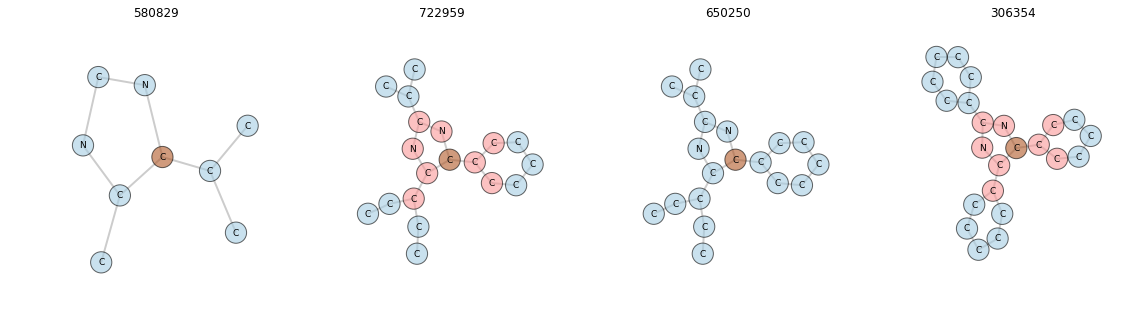

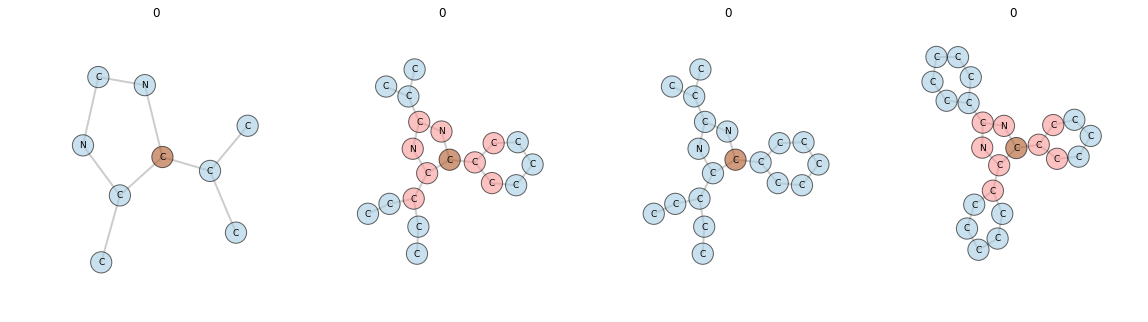

In [5]:
'''
INITIAL TEST OF THINGS 
'''

%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn import graphtools as gt
import graphlearn.utils.draw as myutils
import eden.graph as eg
import graphlearn.graphlearn as gl
import numpy as np

from eden.graph import Vectorizer
vectorizer=Vectorizer()

#get a graph
graphs = gspan_to_eden( 'bursi.pos.gspan' )
graph=graphs.next()
from eden.util import display
from eden.modifier.graph.vertex_attributes import colorize  
graphs = colorize([graph],output_attribute = 'color_level', labels = ['C','O','N','P','Cl','Br','S'])    
graph=graphs.next()
'''
print 'We work on this graph'
display.draw_graph(graph, size=10, secondary_vertex_label='ID',
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, node_size=650)
'''

def mark_and_draw(cips):
    graphs=myutils.cip_to_graph(cips)
    
    for cip,g in zip(cips,graphs):
        g.graph['info']=cip.interface_hash
    
    zomg = lambda x:x.graph['info']
    
    myutils.draw_graph_set_graphlearn(graphs, 
                           n_graphs_per_line=7, size=5, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450,headlinehook=zomg)
radius_list=[0,2]
thickness_list=[2,4]
cips=gl.extract_core_and_interface(1,graph,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
mark_and_draw(cips)
import graphlearn.graphtools as graphtools
test = lambda x,y: 0
graphtools.calc_interface_hash = test
cips=gl.extract_core_and_interface(1,graph,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
mark_and_draw(cips)

In [7]:
%%time
'''
OKOKOKOKOK what i tried above doesnt work .. so i need to change the grammar 
'''
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
from graphlearn.localsubstitutablegraphgrammar import LocalSubstitutableGraphGrammar
from graphlearn import graphtools
from graphlearn import localsubstitutablegraphgrammar
import traceback
import networkx as nx


def _get_args2(self):
    return  [self.radius_list, self.thickness_list, self.vectorizer, self.hash_bitmask, self.node_entity_check,self.esti]

def extract_cores_and_interfaces2(parameters):
    # happens if batcher fills things up with null
    if parameters[0] is None:
        return None
    try:
        # unpack arguments, expand the graph
        graph, radius_list, thickness_list, vectorizer, hash_bitmask, node_entity_check ,esti = parameters
        graph = vectorizer._edge_to_vertex_transform(graph)
        cips = []
        for node in graph.nodes_iter():
            if 'edge' in graph.node[node]:
                continue
            cip_list = graphtools.extract_core_and_interface2(node, graph, radius_list, thickness_list,
                                                                        vectorizer=vectorizer,
                                                                        hash_bitmask=hash_bitmask,
                                                                        filter=node_entity_check,esti=esti)
            if cip_list:
                cips.append(cip_list)
        return cips
    except Exception as exc:
        print 'DONG'
        print traceback.format_exc(10)

    
    
# OVERWRITING FOR TEST PURPOSES
LocalSubstitutableGraphGrammar._get_args=_get_args2    
localsubstitutablegraphgrammar.extract_cores_and_interfaces=extract_cores_and_interfaces2

# learn a grammar
training_graphs = gspan_to_eden( 'bursi.pos.gspan' )
training_size=200
training_graphs = itertools.islice(training_graphs,training_size)
sampler=gl.GraphLearnSampler(radius_list=[0,1,2],thickness_list=[1.5,2],core_interface_pair_remove_threshold=1, interface_remove_threshold=1)
                                    
'''
def fit(self, graphs,
            core_interface_pair_remove_threshold=2,
            interface_remove_threshold=2,
            n_jobs=-1,
            nu=.5,batch_size=10):
        """
          use input to fit the grammar and fit the estimator
        """
        graphs, graphs_ = itertools.tee(graphs)

        self.estimator = self.estimatorobject.fit(graphs_, vectorizer=self.vectorizer, nu=nu, n_jobs=n_jobs)

        self.local_substitutable_graph_grammar.fit(graphs, n_jobs,batch_size=batch_size)
'''
                                              
n_jobs=1
graphs, graphs_ = itertools.tee(training_graphs)
sampler.estimator = sampler.estimatorobject.fit(graphs_, vectorizer=sampler.vectorizer, nu=0.5, n_jobs=n_jobs)
sampler.local_substitutable_graph_grammar.esti= sampler.estimator

graphs=itertools.islice(graphs,10)
sampler.local_substitutable_graph_grammar.fit(graphs, n_jobs,batch_size=10)
sampler.save('tmp/demo_200.ge')



Classifier:
SGDClassifier(alpha=0.000314148141837, average=False, class_weight=None,
       epsilon=0.1, eta0=0.467699667709, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=94, n_jobs=1,
       penalty='l1', power_t=0.391260351488, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
Saved model: tmp/demo_200.ge
CPU times: user 38.8 s, sys: 3.86 s, total: 42.6 s
Wall time: 38.1 s


interface: 0.9676044


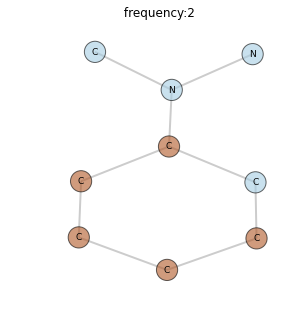

interface: 0.4530046


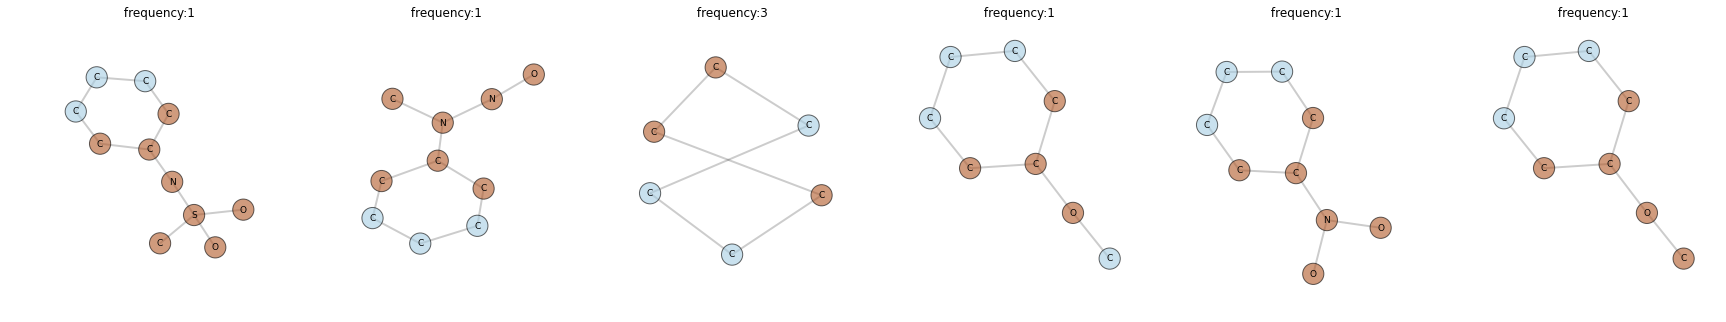

interface: 0.7918613


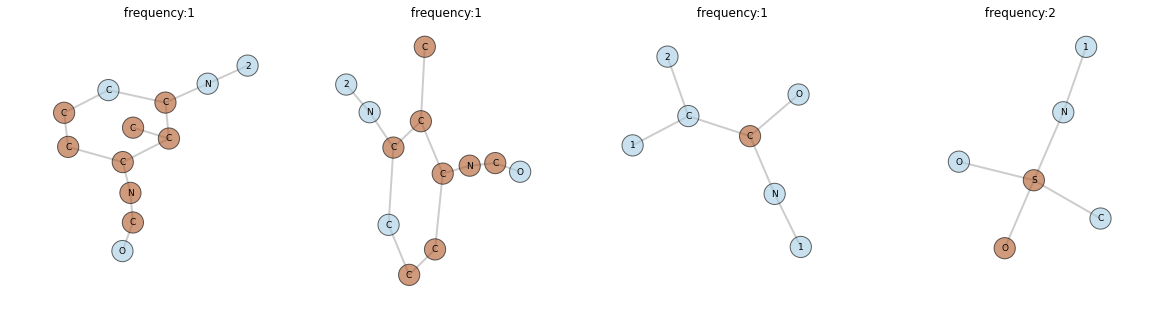

interface: 0.9375887


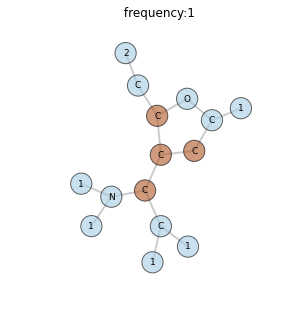

interface: 0.9724603


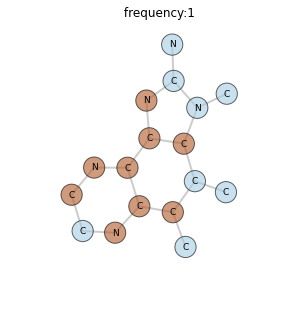

In [8]:
#draw production rules
myutils.draw_grammar(sampler.local_substitutable_graph_grammar.grammar,n_productions=5,
                     n_graphs_per_line=6, size=5, 
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.2, node_size=450)


how often do we see interfacehashes
# productions: 1058
x = # interfaces (total: 176)
y=numberofcores(ihash), y=sumOfCoreCounts(ihash)


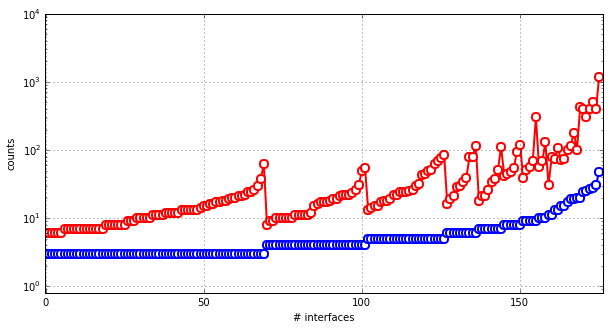

how often was this corehash seen?
x = # cores (total: 173)
y = inYinterfaces(chash), y= sumOfCountOverAllInterfaces(chash)


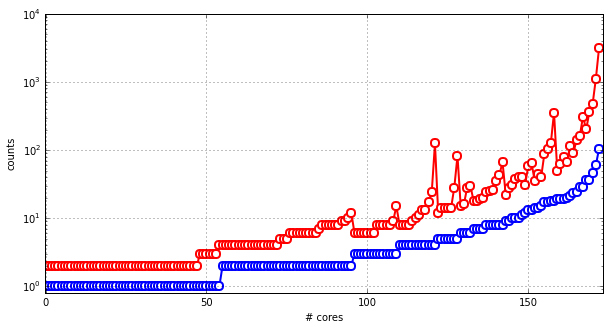

histogram
# productions: 1058
distinct cores: 173 (seen on x axis)
interfaces with x many cores were observed y many times. 


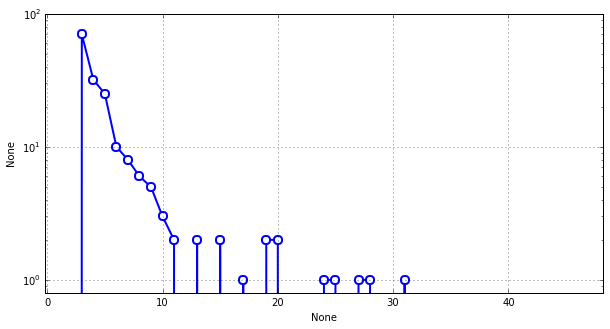

other histogram
how many cores exist with x many interfaces


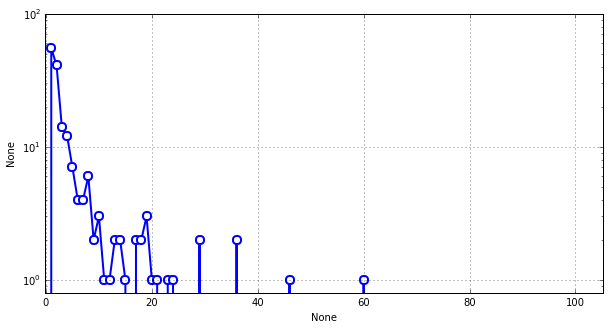

In [12]:
#grammar statistics
myutils.draw_grammar_stats(sampler.local_substitutable_graph_grammar.grammar, size=(10,5))

Loaded model: tmp/demo_200.ge
preprocessing grammar
_sample_notes: None
accept_annealing_factor: 1.2
accept_static_penalty: 0.0
batch_size: 1
   burnout: 1
complexity: 3
 estimator: CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.000852536675604, average=False, class_weight=None,
       epsilon=0.1, eta0=0.157172932749, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=63, n_jobs=1,
       penalty='l1', power_t=0.198621087819, random_state=None,
       shuffle=True, verbose=0, warm_start=False),
            cv=2, method='sigmoid')
estimatorobject: <graphlearn.estimator.estimator instance at 0x7f27a9e496c8>
feasibility_checker: <graphlearn.feasibility.FeasibilityChecker instance at 0x7f27a9e49638>
generatormode: False
hash_bitmask: 1048575
keep_duplicates: False
local_substitutable_graph_grammar: <graphlearn.localsubstitutablegraphgrammar.LocalSubstitutableGraphGrammar object at 0x7f27b008ab50>
    n_jobs: 1
   n_steps: 50
      nbit: 20


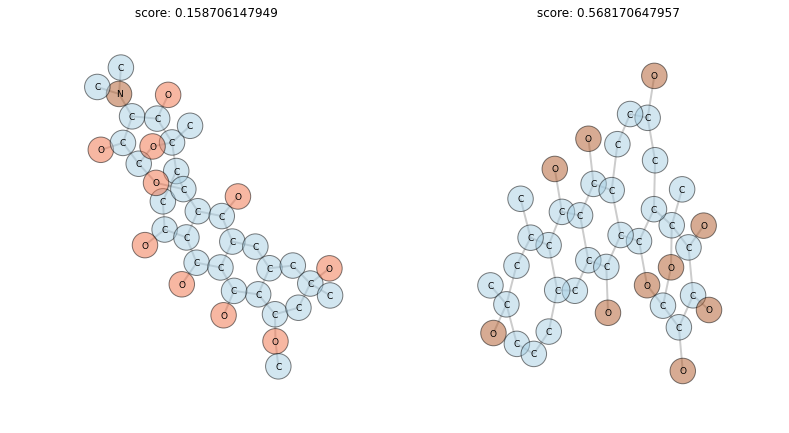

CPU times: user 3.36 s, sys: 80 ms, total: 3.44 s
Wall time: 3.5 s


In [6]:
%%time
'''
Graph sampling
'''
import sys
sys.path.append('..')
import os
os.nice(19)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import matplotlib.pyplot as plt
import graphlearn.utils.draw as myutils
import eden.graph as ge

sampler=gl.GraphLearnSampler()
sampler.load('tmp/demo_200.ge')
graphs = gspan_to_eden( 'bursi.pos.gspan' )
id_start=20
id_end=id_start+1
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=50
sampler.feasibility_checker.draw_problem=True
graphs = sampler.sample(graphs,
                        same_radius=False,
                        same_core_size=False,
                        n_samples=4,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=1,
                        accept_annealing_factor=1.2,
                        probabilistic_core_choice=True,
                        burnout=1,
                        select_cip_max_tries=100,
                        keep_duplicates=False)

from eden.modifier.graph.vertex_attributes import colorize   
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    path_graphs = colorize(path_graphs,
                           output_attribute = 'color_level', 
                           labels = ['C','O','N','P','Cl','Br','S','I'])
    myutils.draw_graph_set(path_graphs,
                           n_graphs_per_line=6, size=7, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.2, node_size=650,
                          headlinehook= myutils.get_score_of_graph
                          )

In [10]:
sampler.feasibility_checker.draw_problem

False

In [12]:
%matplotlib inline
from itertools import islice
import numpy as np
step=n_steps
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

We work on this graph


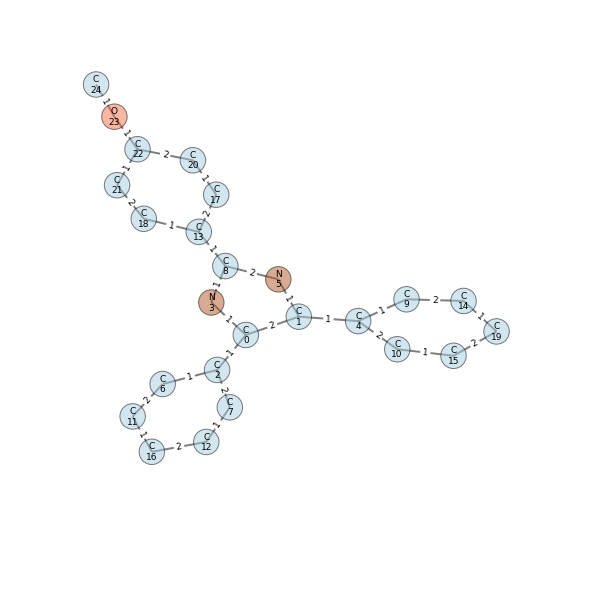

no filter


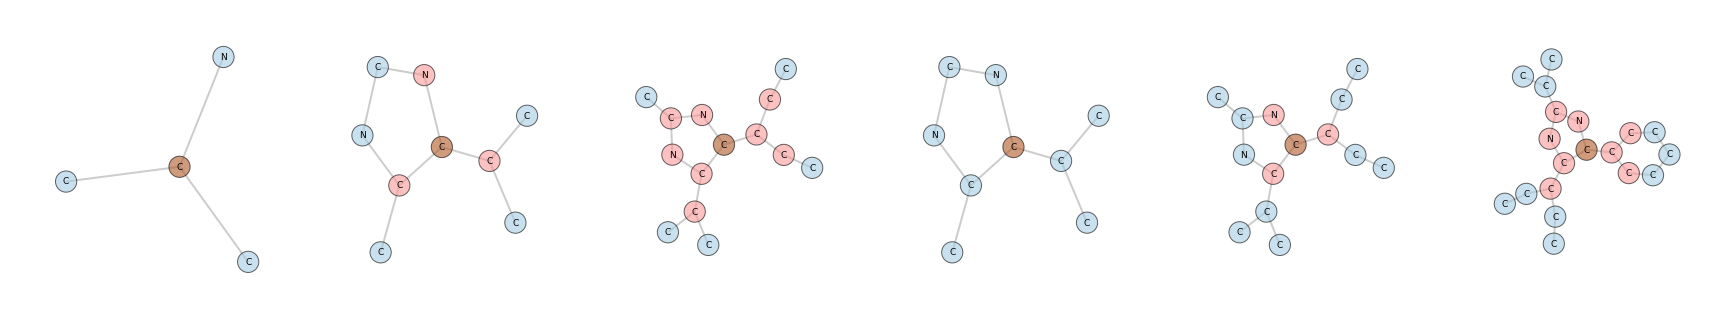

with filter: nothing should appear,,,
with filter but we chose node 2 as root


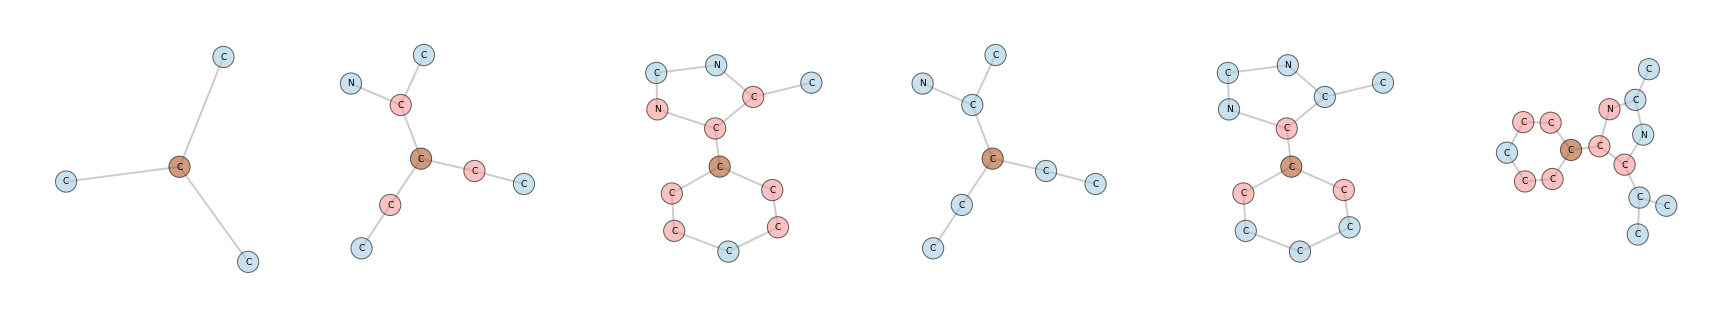

with filter but node "1" cant be part of a core, we gave 0 and 2 as radius list and only radius 2 will show up


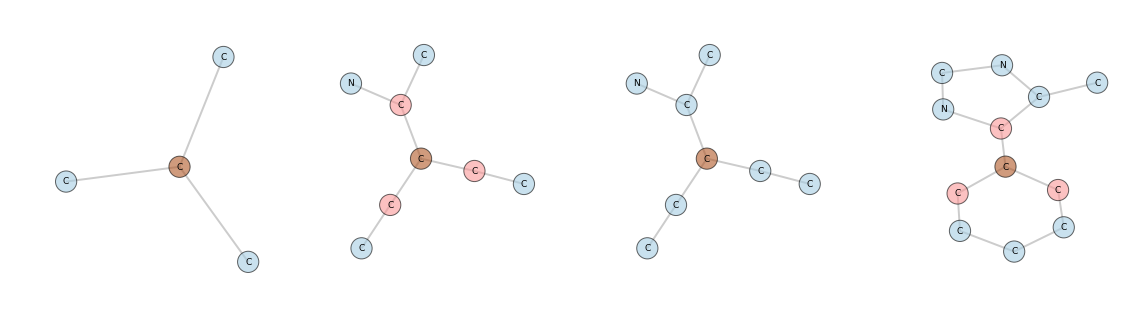

In [12]:
'''
Demonstrating the filter function
'''
import sys
sys.path.append('..')
%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn import graphtools as gt
import graphlearn.utils.draw as myutils
import eden.graph as eg
import graphlearn.graphlearn as gl
import numpy as np

from eden.graph import Vectorizer
vectorizer=Vectorizer()

#get a graph
graphs = gspan_to_eden( 'bursi.pos.gspan' )
graph=graphs.next()
from eden.util import display
from eden.modifier.graph.vertex_attributes import colorize  
graphs = colorize([graph],output_attribute = 'color_level', labels = ['C','O','N','P','Cl','Br','S'])    
graph=graphs.next()
print 'We work on this graph'
display.draw_graph(graph, size=10, secondary_vertex_label='ID',
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, node_size=650)


def mark_and_draw(cip):
    graph=myutils.cip_to_graph(cip)
    myutils.draw_graph_set_graphlearn(graph, 
                           n_graphs_per_line=7, size=5, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450)
    
radius_list=[0,1,2]
thickness_list=[1,2]
graph.node[1]['no_root']=True
#lets see.. without filter:
cip=gl.extract_core_and_interface(1,graph,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'no filter'
mark_and_draw(cip)


# lets do the same but with the filter
cip=gl.extract_core_and_interface(1,graph,filter=gt.filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter: nothing should appear,,,'
mark_and_draw(cip)

# filter is ignoring unfiltered things:
cip=gl.extract_core_and_interface(2,graph,filter=gt.filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter but we chose node 2 as root'
mark_and_draw(cip)

# no core attribute
graph.node[1]["not_in_core"]=True
graph.node[1].pop('no_root')
cip=gl.extract_core_and_interface(2,graph,filter=gt.filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter but node "1" cant be part of a core, we gave 0 and 2 as radius list and only radius 2 will show up'
mark_and_draw(cip)